<a href="https://colab.research.google.com/github/sunidhi-shetty/classical_machine_learning_unsupervised/blob/main/03-Notes-Hierarchical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **Problem Statement: Building Stock Portfolios**

**Goal :** Creating pools of stocks that move together(similar characteristics) on one or more fundamental financial metric.

In previous lecture we studied about K-Means clustering and how we can use it for customer segmentation.

In today's lecture we'll study some other clustering techniques, why they are required, what are the limitations of K-Means, and we'll use all this knowledge to build stock portfolios.

Let's first have a look at the dataset that we'll be using.

#### **Dataset - Top 50 NSE stocks**

- Contains company's stock symbol
- Name, Industry and other details

Lets import the dependencies

In [ ]:
  import pandas as pd
  import numpy as np
  from matplotlib import pyplot as plt
  plt.rcParams["figure.figsize"] = (18,10)
  import seaborn as sns

Reading the data

In [ ]:
!wget "https://drive.google.com/uc?export=download&id=1giO5bbp3l0INVvTQIGJ7s_Ai5_TWNuIb" -O ind_nifty50list.csv

--2022-11-18 10:25:12--  https://drive.google.com/uc?export=download&id=1giO5bbp3l0INVvTQIGJ7s_Ai5_TWNuIb
Resolving drive.google.com (drive.google.com)... 173.194.194.100, 173.194.194.138, 173.194.194.101, ...
Connecting to drive.google.com (drive.google.com)|173.194.194.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/q9rspdri1b647aag9ikgi2okp6btf1ar/1668767100000/10306167880925931714/*/1giO5bbp3l0INVvTQIGJ7s_Ai5_TWNuIb?e=download&uuid=f427ebb8-93a2-4046-9947-09c38c223910 [following]
--2022-11-18 10:25:13--  https://doc-08-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/q9rspdri1b647aag9ikgi2okp6btf1ar/1668767100000/10306167880925931714/*/1giO5bbp3l0INVvTQIGJ7s_Ai5_TWNuIb?e=download&uuid=f427ebb8-93a2-4046-9947-09c38c223910
Resolving doc-08-64-docs.googleusercontent.com (doc-08-64-docs.googleusercontent.com)... 209.85.147.132, 2

**Installing yfinance**


- **yfinance** is a library that helps us download market data from yahoo finance's api.

- So lets install these libraries into our environment using pip.

- You can read more about it <a href="https://pypi.org/project/yfinance/"> here </a>


In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
# Since yfinance is an old library, it also has some glitches, so we install this library as a fix
!pip install fix-yahoo-finance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### EDA
#### **Importing Data**

- Purpose of this dataset: Getting list of Company names which are stored in the 'Symbol' column of the data

In [ ]:
stocks_df = pd.read_csv("./ind_nifty50list.csv")
list_of_symbols = list(stocks_df['Symbol'])
stocks_df.head()

,Company Name,Industry,Symbol,Series,ISIN Code
0,Adani Ports and Special Economic Zone Ltd.,SERVICES,ADANIPORTS,EQ,INE742F01042
1,Asian Paints Ltd.,CONSUMER GOODS,ASIANPAINT,EQ,INE021A01026
2,Axis Bank Ltd.,FINANCIAL SERVICES,AXISBANK,EQ,INE238A01034
3,Bajaj Auto Ltd.,AUTOMOBILE,BAJAJ-AUTO,EQ,INE917I01010
4,Bajaj Finance Ltd.,FINANCIAL SERVICES,BAJFINANCE,EQ,INE296A01024


**Now, we'll take symbols from original dataset**
- We'll add `.NS` at the end of every symbol to fetch data from Yahoo Finance based on company's symbol.

In [ ]:
yf_symbols = list(map(lambda x: x + '.NS', list_of_symbols))
yf_symbols

['ADANIPORTS.NS',
 'ASIANPAINT.NS',
 'AXISBANK.NS',
 'BAJAJ-AUTO.NS',
 'BAJFINANCE.NS',
 'BAJAJFINSV.NS',
 'BPCL.NS',
 'BHARTIARTL.NS',
 'BRITANNIA.NS',
 'CIPLA.NS',
 'COALINDIA.NS',
 'DIVISLAB.NS',
 'DRREDDY.NS',
 'EICHERMOT.NS',
 'GRASIM.NS',
 'HCLTECH.NS',
 'HDFCBANK.NS',
 'HDFCLIFE.NS',
 'HEROMOTOCO.NS',
 'HINDALCO.NS',
 'HINDUNILVR.NS',
 'HDFC.NS',
 'ICICIBANK.NS',
 'ITC.NS',
 'IOC.NS',
 'INDUSINDBK.NS',
 'INFY.NS',
 'JSWSTEEL.NS',
 'KOTAKBANK.NS',
 'LT.NS',
 'M&M.NS',
 'MARUTI.NS',
 'NTPC.NS',
 'NESTLEIND.NS',
 'ONGC.NS',
 'POWERGRID.NS',
 'RELIANCE.NS',
 'SBILIFE.NS',
 'SHREECEM.NS',
 'SBIN.NS',
 'SUNPHARMA.NS',
 'TCS.NS',
 'TATACONSUM.NS',
 'TATAMOTORS.NS',
 'TATASTEEL.NS',
 'TECHM.NS',
 'TITAN.NS',
 'UPL.NS',
 'ULTRACEMCO.NS',
 'WIPRO.NS']

**Now, we'll define some variables and fetch the corresponding data from Yahoo Finance for the companies in our list**

In [ ]:
import yfinance as yf


stock_financials = {
    'marketCap': [],
    'regularMarketVolume': [],
    'earningsQuarterlyGrowth': [],
    'bookValue': [],
    'totalRevenue': [],
    'returnOnAssets': [],
    'profitMargins': [],
    'earningsGrowth': []
    }

for ticker in yf_symbols:
    stock_info = yf.Ticker(ticker).info
    stock_financials['marketCap'].append(stock_info['marketCap'])
    stock_financials['regularMarketVolume'].append(stock_info['regularMarketVolume'])
    stock_financials['earningsQuarterlyGrowth'].append(stock_info['earningsQuarterlyGrowth'])
    stock_financials['bookValue'].append(stock_info['bookValue'])
    stock_financials['totalRevenue'].append(stock_info['totalRevenue'])
    stock_financials['returnOnAssets'].append(stock_info['returnOnAssets'])
    stock_financials['profitMargins'].append(stock_info['profitMargins'])
    stock_financials['earningsGrowth'].append(stock_info['earningsGrowth'])

KeyError: ignored

**Q. What have we collected?**
We 've collected attributes such as '**marketCap**', '**regularMarketVolume**' and others for companies that we collected in variable '**yf_symbols**'

In [ ]:
df = pd.DataFrame(stock_financials)
df.head()

,marketCap,regularMarketVolume,earningsQuarterlyGrowth,bookValue,totalRevenue,returnOnAssets,profitMargins,earningsGrowth
0,1657751076864,12901505,-0.179,180.288,159007899648,NaN,0.28442,-0.207
1,3167850856448,933762,0.789,143.991,319870205952,NaN,0.10876,0.788
2,2221430013952,6403035,0.859,400.581,433654104064,0.01474,0.37225,0.855
3,996960239616,442625,-0.006,1033.043,348966289408,NaN,0.17649,-0.007
4,4343084089344,819955,1.590,724.584,202325999616,NaN,0.42614,1.586


In [ ]:
df.shape

(50, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   marketCap                50 non-null     int64  
 1   regularMarketVolume      50 non-null     int64  
 2   earningsQuarterlyGrowth  47 non-null     float64
 3   bookValue                49 non-null     float64
 4   totalRevenue             50 non-null     int64  
 5   returnOnAssets           18 non-null     float64
 6   profitMargins            50 non-null     float64
 7   earningsGrowth           47 non-null     float64
dtypes: float64(5), int64(3)
memory usage: 3.2 KB


**Downloading stock price data**
- Purpose of this data: Getting returns of the stocks

In [ ]:
import yfinance as yf

stock_prices = yf.download(yf_symbols, start='2020-01-01')['Adj Close']
stock_prices.columns = list_of_symbols

[*********************100%***********************]  50 of 50 completed


 - 'Adj Close' refers to Adjusted close which is used in stock market. It is the closing price after adjustments for all applicable splits and dividend distributions

In [ ]:
stock_prices.shape

(686, 50)

In [ ]:
stock_prices.tail()

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,BRITANNIA,CIPLA,...,SUNPHARMA,TCS,TATACONSUM,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,WIPRO
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-27,844.200012,3470.649902,737.500000,3541.899902,1679.550049,7242.850098,760.599976,310.649994,3824.149902,1098.699951,...,897.150024,797.849976,398.799988,97.650002,3017.449951,1022.500000,2600.350098,6192.850098,677.700012,398.399994
2022-09-28,827.099976,3570.649902,716.450012,3545.899902,1652.199951,7202.500000,761.450012,306.000000,3853.199951,1097.150024,...,917.849976,793.650024,399.100006,95.199997,3035.649902,1029.699951,2576.949951,6172.950195,663.700012,398.049988
2022-09-29,816.400024,3384.800049,719.000000,3476.699951,1635.900024,7104.750000,764.650024,303.250000,3864.500000,1115.849976,...,930.700012,792.599976,402.250000,96.849998,2997.300049,1007.099976,2531.500000,6175.899902,656.799988,392.799988
2022-09-30,820.650024,3342.449951,733.200012,3527.750000,1678.349976,7335.750000,799.900024,304.799988,3843.050049,1114.949951,...,948.650024,802.849976,404.600006,99.300003,3004.550049,1008.599976,2606.949951,6255.100098,672.049988,394.250000
2022-10-03,784.400024,3302.899902,722.750000,3515.350098,1646.599976,7171.799805,803.349976,308.799988,3768.949951,1130.750000,...,944.500000,777.950012,397.649994,98.349998,2984.949951,1005.500000,2574.199951,6242.549805,665.099976,394.500000


In [ ]:
# splitting data by year - 2020 returns
price_2020 = stock_prices.loc["2020-01-02 00:00:00":"2020-12-31 00:00:00"]

# to see % growth of the stock: ((endDate/startDate) - 1) * 100
stock_prices.loc['returns_2020'] = (price_2020.loc['2020-08-04 00:00:00'] / price_2020.loc['2020-01-02 00:00:00'] - 1)*100

stock_prices

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,BRITANNIA,CIPLA,...,SUNPHARMA,TCS,TATACONSUM,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,WIPRO
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,373.521973,1770.856567,748.700012,2913.946289,930.323730,4214.786133,451.678009,401.235748,2883.702881,472.062744,...,422.185242,319.631714,184.449997,27.305548,2100.150635,705.708984,1143.308838,4032.545898,574.207214,245.750504
2020-01-02 00:00:00,378.961853,1768.338379,756.950012,2887.027588,942.936829,4229.478516,453.571259,397.889709,2896.747314,469.682129,...,422.817108,319.138245,193.750000,28.303785,2090.509521,709.366638,1144.150269,4210.910156,581.235352,246.345795
2020-01-03 00:00:00,378.318970,1729.577393,742.950012,2841.747314,927.089966,4177.084473,453.471588,394.584534,2882.896729,466.160767,...,432.197937,314.055328,191.100006,28.236650,2132.171631,717.747009,1128.407837,4185.515137,576.647583,249.123764
2020-01-06 00:00:00,376.044098,1685.878784,723.250000,2809.926025,897.018066,3981.102051,448.041077,382.873505,2867.005859,462.986542,...,427.677612,308.034790,185.649994,27.626617,2131.977783,713.394836,1147.120728,4123.910645,570.986023,250.165482
2020-01-07 00:00:00,380.593811,1702.913940,725.750000,2810.203613,902.270569,3992.009277,443.507385,376.222229,2880.809570,464.821655,...,433.947723,310.798309,184.699997,27.792992,2137.209717,719.599121,1148.457153,4208.231934,580.844910,253.191483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-28 00:00:00,827.099976,3570.649902,716.450012,3545.899902,1652.199951,7202.500000,761.450012,306.000000,3853.199951,1097.150024,...,917.849976,793.650024,399.100006,95.199997,3035.649902,1029.699951,2576.949951,6172.950195,663.700012,398.049988
2022-09-29 00:00:00,816.400024,3384.800049,719.000000,3476.699951,1635.900024,7104.750000,764.650024,303.250000,3864.500000,1115.849976,...,930.700012,792.599976,402.250000,96.849998,2997.300049,1007.099976,2531.500000,6175.899902,656.799988,392.799988
2022-09-30 00:00:00,820.650024,3342.449951,733.200012,3527.750000,1678.349976,7335.750000,799.900024,304.799988,3843.050049,1114.949951,...,948.650024,802.849976,404.600006,99.300003,3004.550049,1008.599976,2606.949951,6255.100098,672.049988,394.250000


In [ ]:
stock_prices = stock_prices.transpose()
stock_prices.head()

Date,2020-01-01 00:00:00,2020-01-02 00:00:00,2020-01-03 00:00:00,2020-01-06 00:00:00,2020-01-07 00:00:00,2020-01-08 00:00:00,2020-01-09 00:00:00,2020-01-10 00:00:00,2020-01-13 00:00:00,2020-01-14 00:00:00,...,2022-09-21 00:00:00,2022-09-22 00:00:00,2022-09-23 00:00:00,2022-09-26 00:00:00,2022-09-27 00:00:00,2022-09-28 00:00:00,2022-09-29 00:00:00,2022-09-30 00:00:00,2022-10-03 00:00:00,returns_2020
ADANIPORTS,373.521973,378.961853,378.318970,376.044098,380.593811,381.434509,387.517273,387.764557,386.083160,384.945740,...,932.900024,946.650024,913.799988,863.400024,844.200012,827.099976,816.400024,820.650024,784.400024,-16.891368
ASIANPAINT,1770.856567,1768.338379,1729.577393,1685.878784,1702.913940,1707.259033,1750.463867,1770.214722,1782.410889,1796.483398,...,3356.050049,3436.000000,3395.250000,3438.050049,3470.649902,3570.649902,3384.800049,3342.449951,3302.899902,-3.813726
AXISBANK,748.700012,756.950012,742.950012,723.250000,725.750000,724.500000,742.849976,740.049988,737.400024,747.900024,...,806.549988,789.200012,768.599976,742.599976,737.500000,716.450012,719.000000,733.200012,722.750000,-43.305372
BAJAJ-AUTO,2913.946289,2887.027588,2841.747314,2809.926025,2810.203613,2829.906982,2854.374023,2868.711914,2862.098145,2869.082275,...,3730.600098,3728.899902,3698.899902,3574.500000,3541.899902,3545.899902,3476.699951,3527.750000,3515.350098,-0.566448
BAJFINANCE,930.323730,942.936829,927.089966,897.018066,902.270569,907.215576,931.990356,929.708740,937.942200,947.822266,...,1802.000000,1772.349976,1721.900024,1676.800049,1679.550049,1652.199951,1635.900024,1678.349976,1646.599976,-34.809406


**Putting the data together**

In [ ]:
prices = stock_prices.iloc[:, -1]
df.index = stock_prices.index
df['return_2020'] = prices
df.head()

,marketCap,regularMarketVolume,earningsQuarterlyGrowth,bookValue,totalRevenue,returnOnAssets,profitMargins,earningsGrowth,return_2020
ADANIPORTS,1657751076864,12901505,-0.179,180.288,159007899648,NaN,0.28442,-0.207,-16.891368
ASIANPAINT,3167850856448,933762,0.789,143.991,319870205952,NaN,0.10876,0.788,-3.813726
AXISBANK,2221430013952,6403035,0.859,400.581,433654104064,0.01474,0.37225,0.855,-43.305372
BAJAJ-AUTO,996960239616,442625,-0.006,1033.043,348966289408,NaN,0.17649,-0.007,-0.566448
BAJFINANCE,4343084089344,819955,1.590,724.584,202325999616,NaN,0.42614,1.586,-34.809406


**Checking for null values**

In [ ]:
df.isna().sum()

marketCap                   0
regularMarketVolume         0
earningsQuarterlyGrowth     3
bookValue                   1
totalRevenue                0
returnOnAssets             32
profitMargins               0
earningsGrowth              3
return_2020                 0
dtype: int64

In [ ]:
df['returnOnAssets'] = df['returnOnAssets'].replace(np.nan, 0)

In [ ]:
df.dropna(axis=0, inplace=True)
df.shape

(46, 9)

In [ ]:
df.head()

,marketCap,regularMarketVolume,earningsQuarterlyGrowth,bookValue,totalRevenue,returnOnAssets,profitMargins,earningsGrowth,return_2020
ADANIPORTS,1657751076864,12901505,-0.179,180.288,159007899648,0.00000,0.28442,-0.207,-16.891368
ASIANPAINT,3167850856448,933762,0.789,143.991,319870205952,0.00000,0.10876,0.788,-3.813726
AXISBANK,2221430013952,6403035,0.859,400.581,433654104064,0.01474,0.37225,0.855,-43.305372
BAJAJ-AUTO,996960239616,442625,-0.006,1033.043,348966289408,0.00000,0.17649,-0.007,-0.566448
BAJFINANCE,4343084089344,819955,1.590,724.584,202325999616,0.00000,0.42614,1.586,-34.809406


**Q. Should we Scale the values?**

- The data seems to be in different scales
- Different financial metrics have different scales.
- We need to put them on the same scale.

We can use `StandardScaler` from `sklearn`

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df)
X = scaler.transform(df)

In [ ]:
scaled_df = pd.DataFrame(X, columns=df.columns, index=df.index)

In [ ]:
scaled_df

,marketCap,regularMarketVolume,earningsQuarterlyGrowth,bookValue,totalRevenue,returnOnAssets,profitMargins,earningsGrowth,return_2020
ADANIPORTS,-0.383732,0.817828,-0.719520,-0.484327,-0.642720,-0.504524,1.205336,-0.759821,-0.360298
ASIANPAINT,0.133385,-0.496196,0.330622,-0.540867,-0.507665,-0.504524,-0.508547,0.340752,0.112946
AXISBANK,-0.190706,0.104314,0.406562,-0.141175,-0.412136,-0.250331,2.062278,0.414861,-1.316149
BAJAJ-AUTO,-0.610013,-0.550122,-0.531840,0.844016,-0.483237,-0.504524,0.152283,-0.538600,0.230456
BAJFINANCE,0.535830,-0.508692,1.199593,0.363527,-0.606352,-0.504524,2.588073,1.223423,-1.008703
BAJAJFINSV,-0.053153,-0.438011,0.095208,-0.371209,-0.197357,-0.504524,-0.857451,0.104046,-0.603871
BHARTIARTL,0.686134,0.786739,4.538784,-0.588886,0.256575,-0.504524,-1.127227,4.404577,-0.169372
BRITANNIA,-0.640379,-0.571071,-0.670701,-0.599730,-0.655394,-0.504524,-0.571283,-0.679076,1.206772
CIPLA,-0.638859,-0.313085,-0.568725,-0.362774,-0.594584,-0.504524,-0.447469,-0.575102,2.102000
COALINDIA,-0.497789,0.652575,1.413310,-0.656114,0.180074,-0.504524,0.402253,1.446856,-0.961650


## **Hierarchical Clustering**

There are two ways of performing Hierarchical Clustering
  
  1. Agglomerative (Popular and Widely used)
  2. Divisive

#### What is Agglomerative Clustering?

- The word agglomerative suggests combining things
- It is a **bottom-up** approach
- Agglomerative clustering starts with the assumption that every datapoint is a cluster
- Then, it groups the clusters which are closed to each other until there is only a single cluster left

<img src="https://drive.google.com/uc?export=view&id=1QFeq1V0dwWXwwM8WvCUbN3Z8Wrw14y3a">

#### What is Divisive Clustering?

- It is an complete opposite of agglomerative approach
- It is a **top-down** approach
- It starts with one big clusters that conatins all the datapoints.
- It then divides the points into different clusters till each data point is a cluster itself

### What does the Agglomerative Algorithm look like?
Now, let's dive a little deep into Agglomerative approach


1. Assume each point is a cluster (n datapoints -> n clusters)
2. Compute Proximity Matrix  ($P_{n*n})$
3. Repeat until a single cluster is left:
  - Merge the closest clusters
  - Update the proximity matrix

- If we visualize this, this looks like a Tree, but there is other name which is often used in Data Mining terminology which is called **Dendogram**

<img src="https://drive.google.com/uc?export=view&id=1neRTN8VRhRVcfyWMFv9ptYysH50wJAOF">

Given below is a very nice animation which depicts the same process.

In [ ]:
from IPython.display import Image
Image(url='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/015/038/original/hierarch.gif?1663699414')

#### Q. What is the advantage of the 1 large cluster?

- Unlike K-Means, we don't have to specify the value of $K$ before clustering
- According the domain application, one has the flexibility to choose the number of clusters post-clustering from the dendogram

<img src="https://drive.google.com/uc?export=view&id=1cJjTlD7l8IRiC-hipvbGHFSFvKJzPSEW">

#### Q. What is proximity matrix?

- It is a matrix of distances or similarity
- The word proximity suggests how close things are
- Say, at any point we're having $C_{m}$ clusters. For each of the pairs of the clusters, the proximity matrix $P$, will indicate similarity between clusters $C_{i}$ and $C_{j}$,
- i.e. $P_{ij} = sim(C_{i}, C_{j})$

##### Q. How to update proximity matrix?

- Intially the proximity $P$ matrix will be $N*N$ matrix
- Suppose cluster $C_{i}$ and $C_{j}$, where $i \neq j$, are similar and they have the smallest value in proximity matrix, then those clusters will be combined and proximity matrix will get updated
- The new matrix will be a $N-1 * N-1$ matrix, as two clusters have combined

<img src="https://drive.google.com/uc?export=view&id=1zaCwOvWqFaZzabJeU8s0j5rcAlnAd4nX">
<img src="https://drive.google.com/uc?export=view&id=1VKxRxgN9QOnY4wzIjNvNkb2dpCIKSUKZ">

#### Q. How to compute values of Proximity matrix?
1. Using Euclidean Distance between the centroids of two clusters $C_{i}$ and $C_{j}$

2. Maximum distance between two points $x_{i}$ and $x_{j}$, such that $x_{i} \in C_{i}$ and $x_{j} \in C_{j}$

3. Minimum distance between two points $x_{i}$ and $x_{j}$, such that $x_{i} \in C_{i}$ and $x_{j} \in C_{j}$

4. Average Distance: $\sum_{x_{i} \in C{_i}} \sum_{x_{j} \in C_{j}} \frac{dist(x_{i}x_{j})}{|C_{i}| |C_{j}|}$

5. Wards' Distance: $\sum_{x_{i} \in C{_i}} \sum_{x_{j} \in C_{j}} \frac{dist(x_{i}x_{j})^2}{|C_{i}| |C_{j}|}$

<img src="https://drive.google.com/uc?export=view&id=1M1FpMdWCR0mguraBLqiWuy82Gn8DZzoW">

<img src="https://drive.google.com/uc?export=view&id=1s6BqKsj8G0N0GJYM3MGPvCuXysCC1heN">

- Consider a data with 6 datapoints marked in black.
- In proximity matrix, values for $(3,6)$ is lowest (same as $(6,3)$)
- We group them together

- Now, how to compute distance of a cluster (3,6) to other points?

- If you observe the table, the distance between $(3,1) < (6,1)$ {0.22 < 0.23} and similarly, distance between $(3,2) < (6,2)$ {0.15 < 0.25}.

- So, we use values of point 3 as values for grouped cluster $C_{36}$ and remove the values of the point 6. So, $5*5$ will be the updated dimension of the proximity matrix.

- Next, next least value in matrix is for points $(2,5)$, and hence we group them together, and we continue to do this iteratively until only 1 cluster is left.

If we use different distance methods to compute proximity matrix,can the results be different?

- Yes! Different methods can result into formation of different clusters.

<img src="https://drive.google.com/uc?export=view&id=1eacz9GXWHJAOjSCid-l661TdVIayd3cz">

## Hierarchical Clustering Implementation

So, we saw how powerful Hierarchical clustering is.

Let's now use this for solving our today's use case, that is, how can we enhance our portfolio allocation by leveraging some Data Science techniques!!!


#### Performing Agglomerative Clustering


In [ ]:
# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch

# Refer https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
Z = sch.linkage(scaled_df, method='ward') #linkage = ward

In [ ]:
Z.shape

(45, 4)

In [ ]:
Z

array([[16.        , 34.        ,  0.46101877,  2.        ],
       [13.        , 44.        ,  0.90243818,  2.        ],
       [ 1.        ,  5.        ,  0.95407898,  2.        ],
       [ 0.        , 32.        ,  0.95544617,  2.        ],
       [ 7.        ,  8.        ,  0.98202714,  2.        ],
       [18.        , 29.        ,  1.00202302,  2.        ],
       [23.        , 26.        ,  1.06042011,  2.        ],
       [14.        , 45.        ,  1.07030537,  2.        ],
       [42.        , 43.        ,  1.14805649,  2.        ],
       [12.        , 17.        ,  1.18091394,  2.        ],
       [41.        , 46.        ,  1.21730689,  3.        ],
       [ 3.        , 47.        ,  1.35064841,  3.        ],
       [37.        , 50.        ,  1.3508401 ,  3.        ],
       [27.        , 48.        ,  1.54946895,  3.        ],
       [ 2.        ,  4.        ,  1.70714487,  2.        ],
       [19.        , 21.        ,  1.72978216,  2.        ],
       [36.        , 51.

Text(0, 0.5, 'distance')

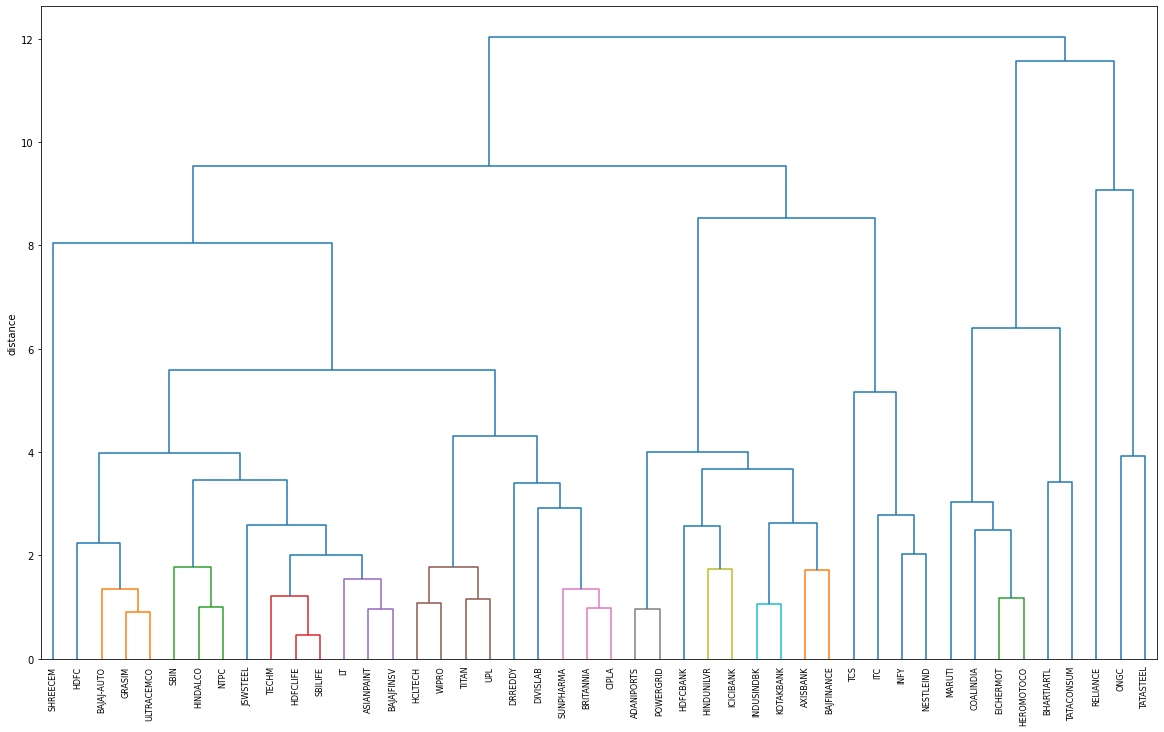

In [ ]:
fig, ax = plt.subplots(figsize=(20, 12))
sch.dendrogram(Z, labels=scaled_df.index, ax=ax, color_threshold=2)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

#### **Interpreting the Dendrogram**
- Note that we are now plotting companies that are similar to one another.
- The leaves of the tree correspond to the records.
- The length of the branch in the tree indicates the degree of dissimilarity between corresponding clusters.
- All the clusterings are made in the 8 dimensional space

#### **Insights**
- We may think that companies working in same field will have similar trends in stocks and will be clustered together.
- In some cases, this is right. For example, we can see that AXISBANK, HDFCBANK, BAJAJFINANCE will be grouped together.
- While in some cases, it is not. Such as chances of tech companies like TCS, WIPRO, TECHMAHINDRA grouping together are only when we set the number of clusters very low.

#### **Calculating the number of clusters**

Text(0, 0.5, 'distance')

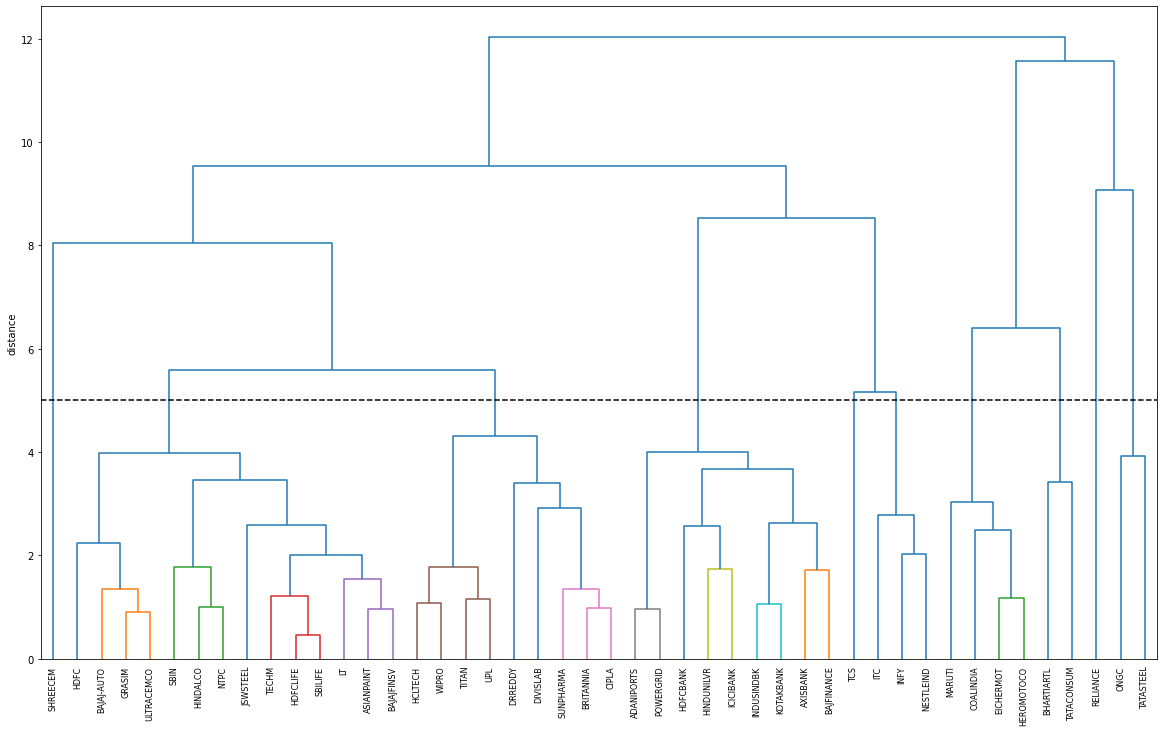

In [ ]:
fig, ax = plt.subplots(figsize=(20, 12))
sch.dendrogram(Z, labels=scaled_df.index, ax=ax, color_threshold=2)
plt.xticks(rotation=90)
plt.axhline(y=5, color='k', linestyle='--')
ax.set_ylabel('distance')

#### **Performing Agglomerative Clustering with 5 clusters**

In [ ]:
# import hierarchical clustering libraries
from sklearn.cluster import AgglomerativeClustering


# create clusters
hc_2020 = AgglomerativeClustering(n_clusters=5, affinity = 'euclidean', linkage = 'ward')
y_pred = hc_2020.fit_predict(scaled_df)

In [ ]:
y_pred

array([0, 1, 0, 1, 0, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 2, 1, 0, 3, 0, 4, 1, 1, 1, 1, 0, 2, 3, 1, 1, 1,
       1, 1])

In [ ]:
viz_df = scaled_df
viz_df['Y_Predicted'] = y_pred

In [ ]:
viz_df.head()

,marketCap,regularMarketVolume,earningsQuarterlyGrowth,bookValue,totalRevenue,returnOnAssets,profitMargins,earningsGrowth,return_2020,y_km,y_km2,y_km3,Y_Predicted
ADANIPORTS,-0.383732,0.817828,-0.719520,-0.484327,-0.642720,-0.504524,1.205336,-0.759821,-0.360298,1,1,0,0
ASIANPAINT,0.133385,-0.496196,0.330622,-0.540867,-0.507665,-0.504524,-0.508547,0.340752,0.112946,1,1,0,1
AXISBANK,-0.190706,0.104314,0.406562,-0.141175,-0.412136,-0.250331,2.062278,0.414861,-1.316149,1,2,1,0
BAJAJ-AUTO,-0.610013,-0.550122,-0.531840,0.844016,-0.483237,-0.504524,0.152283,-0.538600,0.230456,1,1,0,1
BAJFINANCE,0.535830,-0.508692,1.199593,0.363527,-0.606352,-0.504524,2.588073,1.223423,-1.008703,1,2,1,0


##### **Plotting the characteristics of the learned clusters**

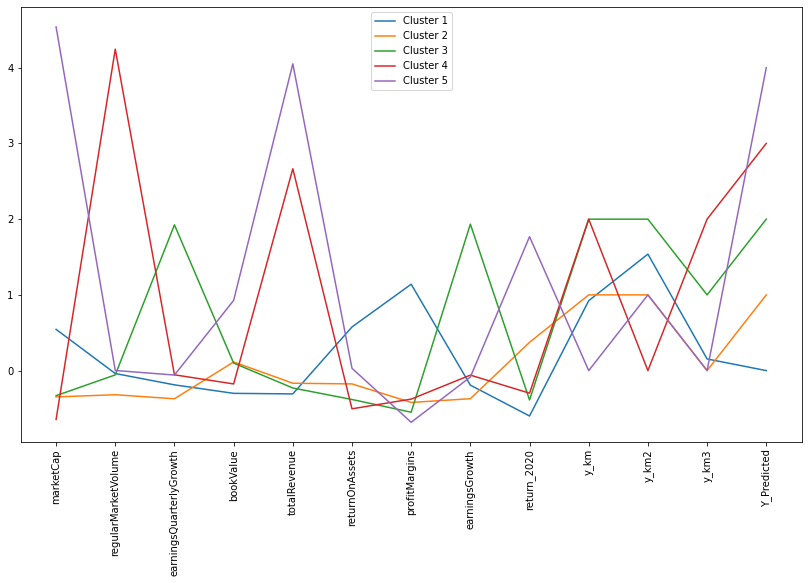

In [ ]:
#Plot a line graph to see the characteristics of the clusters
scaled_df['label'] = pd.Series(y_pred, index=scaled_df.index)

clustered_df = scaled_df.groupby('label').mean()

labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']

plt.figure(figsize=(14,8))
plt.plot(clustered_df.T, label=labels)
plt.xticks(rotation=90)
plt.legend(labels)


##### **Looking at this, What characteristics do we find unique in each of these learned cluster?**

- **Cluster 1** - Companies with average market capital, quarterly growth, total revenue returning average returns

- **Cluster 2** - Companies havning largest market capital, with low quaterly growth (because they are already dominating), high total revenue, and highest return

- **Cluster 3** - Trader's favourites - high market volume with good profit margins.

- **Cluster 4** - Low market capital, with low quarterly growth, having high total revenue, with second largest returns

- **Cluster 5** - low market cap, with very high quarterly growth, but lowest total revenue and returns

This way, with the help of Hierarchical Clustering, we can draw conclusions on how different data points are grouped into different clusters, and also get information about the features of the dataset based on which the grouping is done.

***

#### Comparing Hierarchical Clustering with K-Means++

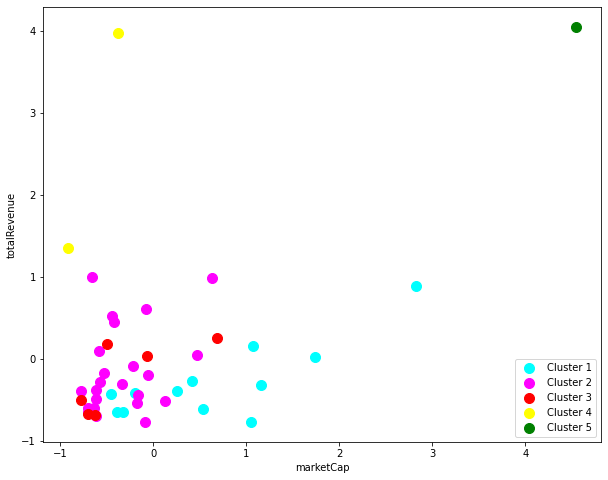

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(viz_df[viz_df['Y_Predicted'] == 0]['marketCap'], viz_df[viz_df['Y_Predicted'] == 0]['totalRevenue'], s=100, c='Cyan', label='Cluster 1')
plt.scatter(viz_df[viz_df['Y_Predicted'] == 1]['marketCap'], viz_df[viz_df['Y_Predicted'] == 1]['totalRevenue'], s=100, c='Magenta', label='Cluster 2')
plt.scatter(viz_df[viz_df['Y_Predicted'] == 2]['marketCap'], viz_df[viz_df['Y_Predicted'] == 2]['totalRevenue'], s=100, c='Red', label='Cluster 3')
plt.scatter(viz_df[viz_df['Y_Predicted'] == 3]['marketCap'], viz_df[viz_df['Y_Predicted'] == 3]['totalRevenue'], s=100, c='Yellow', label='Cluster 4')
plt.scatter(viz_df[viz_df['Y_Predicted'] == 4]['marketCap'], viz_df[scaled_df['Y_Predicted'] == 4]['totalRevenue'], s=100, c='Green', label='Cluster 5')
plt.xlabel('marketCap')
plt.ylabel('totalRevenue')
plt.legend()
plt.show()

From the dendogram one important thing we concluded was that we may think comanies in the same industries will have same stock figures, it is often the opposite.

From the clusters shown in the results of hierarchical clustering, you will observe that though points which are very close to each other belongs to other clusters.

This often happens in the real world and this is where KMeans/KMeans++ would not give effective results.

Let's also see K-Means++ results which would give more intuition.

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=5, init = 'k-means++', random_state = 50)
y_km = km.fit_predict(scaled_df)

In [ ]:
viz_df['km_predicted'] = y_km

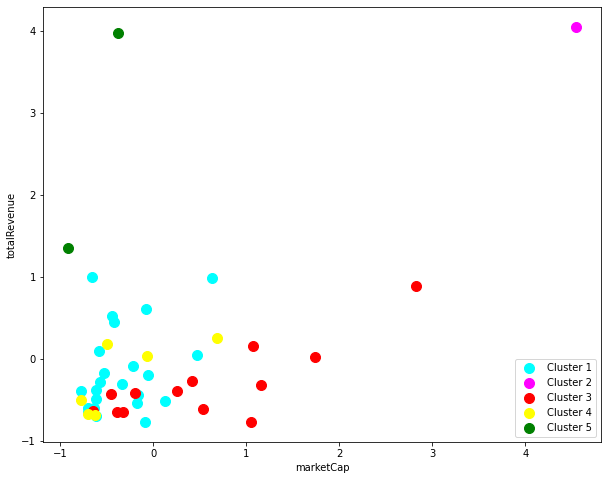

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(viz_df[viz_df['km_predicted'] == 0]['marketCap'], viz_df[viz_df['km_predicted'] == 0]['totalRevenue'], s=100, c='Cyan', label = 'Cluster 1')
plt.scatter(viz_df[viz_df['km_predicted'] == 1]['marketCap'], viz_df[viz_df['km_predicted'] == 1]['totalRevenue'], s=100, c='Magenta', label = 'Cluster 2')
plt.scatter(viz_df[viz_df['km_predicted'] == 2]['marketCap'], viz_df[viz_df['km_predicted'] == 2]['totalRevenue'], s=100, c='Red', label = 'Cluster 3')
plt.scatter(viz_df[viz_df['km_predicted'] == 3]['marketCap'], viz_df[viz_df['km_predicted'] == 3]['totalRevenue'], s=100, c='Yellow', label = 'Cluster 4')
plt.scatter(viz_df[viz_df['km_predicted'] == 4]['marketCap'], viz_df[scaled_df['km_predicted'] == 4]['totalRevenue'], s=100, c='Green', label = 'Cluster 5')

plt.xlabel('marketCap')
plt.ylabel('totalRevenue')
plt.legend()
plt.show()

## **Limitations of Agglomerative Complexity**

1. With large datasets, Agglomerative Clustering does not work well

  - Space Complexity = $O(n)$ : Proximity Matrix

  - Time Complexity = $O(n^2)$

<img src="https://drive.google.com/uc?export=view&id=1ccxO0Q1fcjWTRA9HmWRMTT-Gm8nkBr8O">

2. Unlike K-means where we try to minimize **within-cluster distance**, there is  **no mathematical objective** that is being minimized in Agglomerative clustering

***
***

<!-- **Instructor Notes**

There is a post read following this lecture which contains two topics:
  1. K-Medoids
  2. Pros and Cons of using different methods to update Proximity Matrix.

Encourage students to give it a read.

https://colab.research.google.com/drive/14eo3Q-SwHJg767_DE4RP0j6f5vdZHEq6?usp=sharing -->